# Backprop своими руками

Материалы:

* [Andrew Karpahy: yes, you should understand backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
* [Stanford CS231n](http://cs231n.stanford.edu/)
* [Deep Learning](http://sereja.me/f/deep_learning_goodfellow.pdf) — с 204 страницы и до прозрения
* [Xavier, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

<img width='800px' src='https://cdn-images-1.medium.com/max/1600/1*q1M7LGiDTirwU-4LcFq7_Q.png'>

Иногда сети пишут на чистом C++, причём код для обучения и инференса (реального прогона в продакшне) — отдельно. Так делают, когда нужен очень быстрый отклик и высокая производительность, но это очень трудоемко.

Большинство людей не усложняют себе жизнь и просто используют фреймворки — с ними можно просто почти декларативно описать, какие операции хотите сделать с данными, а он потом сам построит сеть и подгонит её под данные.

Ваше задание — реализовать свой небольшой фреймворк глубокого обучения на чистом `numpy`. Основное время у вас должно уйти на вывод формул для градиентов, анализ поведения самых часто используемых слоев в современных нейросетях и прочий матан. Хотя бы один раз в жизни это надо сделать, а уже потом пользоваться готовыми абстракциями.

Предполагаемый порядок выполнения:
* Поймите на высоком уровне, как работает алгоритм backpropagation
* Изучите пример с логиситической регрессией, чтобы понять, что от вас в итоге хотят
* Изучите код `Module`
* `Sequential`
* `Linear`
* `SoftMax`
* `CrossEntropy`
* Протестируйте их на логситической регрессии
* Напишите код для решения MNIST
* Дописывайте остальные слои, пока не получите на нём 97%

Оценивание (суммарно до 20 баллов):
* 5 баллов -- что-то хоть как-то обучается, MNIST на валидации >90%
* 2 балла -- MNIST на 95%, дальше по одному баллу за 96%, 97% и 98%. Это будет сделать намного сложнее, чем через PyTorch, потому что вам всё нужно писать самим: более сложные оптимизаторы, learning rate decay, думать про численную стабильность и т. д.
* По 2 балла за слои: LeakyReLU, Dropout, BatchNorm, CrossEntropy, SoftMax

Советы:
* Чтобы лучше понять, что должно в итоге получиться, изучите «игрушечный пример» и вообще эту тетрадку, а потом начните читать `hw_framework.py`, где будет более техничное описание.
* Для дебага проверяйте градиенты численно — сдвигайте параметры на какой-нибудь эпсилон и смотрите разницу. Ещё можете проверить, что на одинаковых данных они дают то же, что их эквиваленты из PyTorch (можно после каждого нового слоя добавить юнит тест через `assert`).
* Пишите код без циклов — в питоне они очень долгие; все вычисления можно делать внутри numpy.
* Ограничение на срок сдачи большое — до конца всего курса, но рекомендуется закончить примерно за месяц. Дописывайте его постепенно, разбираясь, как работает каждая функция активации.
* Обсуждайте математику и общую архитектуру фреймворка, но не шарьте друг другу код — так не интересно.

In [732]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [733]:
def set_seed(seed):
    np.random.seed(seed)

set_seed(42)

---

Откройте в Jupyter две тетрадки — эту и `hw_framework.ipynb`. В этой содержится train loop, а там непосредственно ваш «фреймворк», который вам ещё предстоит написать.

Архитектура фреймворка вдохновлена PyTorch. Как всегда, если придумаете какой-то более клёвый дизайн — можете использовать его.

In [734]:
%run hw_framework.ipynb

Wall time: 109 ms
Wall time: 0 ns


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\IPython\core\magic.py:187: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  call = lambda f, *a, **k: f(*a, **k)


Мы будем использовать самый простой вариант градиентного спуска: просто пройдемся по всем параметрам и сделаем шаги в сторону уменьшения посчитанного заранее градиента.

Есть [более продвинутые методы](http://ruder.io/optimizing-gradient-descent/), но пока что мы их использовать не будем.

In [735]:
def SGD(params, gradients, lr=1e-3):    
    for weights, gradient in zip(params, gradients):
        #print(type(lr), type(gradient))
        #print(lr, gradient)
        weights -= lr * gradient

Cоздадим обертку вокруг нашего датасета (просто numpy-евские массивы), которую будем потом использовать, чтобы итерироваться по нему.

In [736]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    # важно, что мы пермешиваем индексы, а не X
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        # в конце нам, возможно, нужно взять неполный батч
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

В следующих двух секциях — игрушечные примеры регрессии и классификации на синтезированных данных. В них ничего менять не надо — они нужны, чтобы отдебажить ваши слои в `hw_framework`.

# Линейная регрессия

### Модель

In [737]:
n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = np.dot(X, true_w).reshape(n, 1) + np.random.randn(n, 1)/5

print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w).reshape(n), 2)))

model = Sequential(
    Linear(10, 1),
)

criterion = MSE()

best_possible_mse: 15.346755005907184


### Обучение

In [738]:
epochs = 10
batch_size = 20
learning_rate = 1e-1

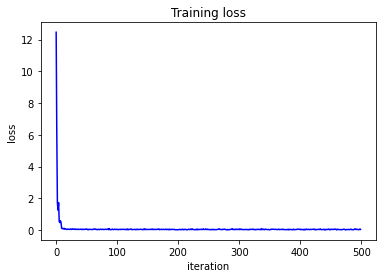

In [739]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)

        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

# Логистическая регрессия

Этот пример нужнен для теситрования классификации (`CrossEntropy` и `SoftMax`).

Возьмем в качестве датасета точки из двух гауссиан на плоскости.

Обратите внимание на `y`. Он в формате one-hot: у каждого вектора все нули, кроме одной единицы.

Выходные данные в таком формате упростят написание `CrossEntropy`.

### Модель

Логистическая регрессия — это тоже как бы маленькая нейронка: линейный слой, софтмакс, и максимизируем правдоподобие.

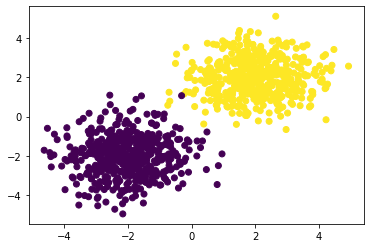

In [740]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]

plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

Y = np.hstack([Y, 1-Y])

model = Sequential(
    Linear(2, 2),
    SoftMax()
)

criterion = CrossEntropy()

### Обучение

In [741]:
epochs = 10
batch_size = 16
learning_rate = 1e-2

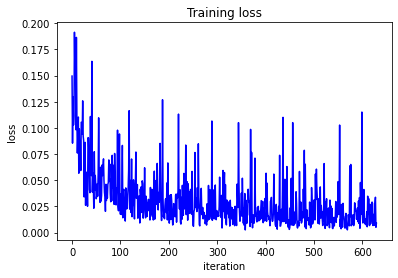

In [742]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
    
        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)

        # логгируем лосс
        history.append(loss)
    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

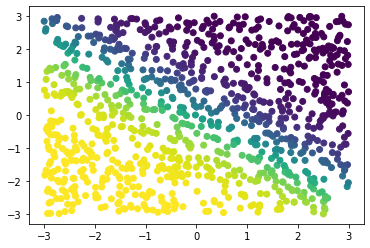

In [743]:
X = np.random.random((1000, 2)) * 6 - 3
Y = model.forward(X)

plt.scatter(X[:, 0], X[:, 1], c=Y[:, 1])
plt.show()

Мы тут пропустили много важных деталей: валидация, подсчет точности (кроссэнтропия не очень информативна), регуляризация. Вам всё это нужно будет реализовать потом самим.

# Теперь сами

## Скачиваю MNIST

In [744]:
import os
from sklearn.datasets import fetch_openml

if os.path.exists('mnist.npz'):
    data = np.load("mnist.npz", allow_pickle=True)
    X = data['X']
    y = data['y']
else:
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    # очень важно его отнормировать -- см. Linear в hw_framework
    X /= 255.0
    np.savez('mnist.npz', X=X, y=y)

Переведите лейблы в one-hot.

In [745]:
from sklearn.preprocessing import OneHotEncoder
target = OneHotEncoder().fit_transform(y.reshape(-1,1)).toarray()

Разделите датасет на train и validation.

In [746]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.1)

Теперь напишите модель и train loop. Можете начать с адаптации предыдущего примера.

Дальше начинается творческая часть и настоящий Deep Learning:
* поиграйтесь с архитектурами;
* поиграйтесь с learning rate и batch_size;
* сделайте learning rate decay;
* сделайте data augmentation.

Have fun. Дедлайн — не две недели, а до конца курса.

In [747]:
def accuracy(model, val):
    model.eval()
    total = 0
    correct = 0
    for x, y in val:
        x = x.reshape(-1, 784)
        res = model.forward(x)
        res = res.argmax(axis=1)
        y = y.argmax(axis=1)
        total += res.shape[0]
        correct += (res == y).sum()
    return correct / total

## Модель
Модель использую почти такую же, как и в первой ДЗ. Единственное отличие - это использование Dropout-а. Т.к. эпох очень много нужна регуляризация.

В первой ДЗ результат в 97.6% достигался за 20 эпох, здесь же не хватило 75 эпох)

Также, как и в первой ДЗ картику перевожу в вектор, через reshape(-1, 784)

In [750]:
epochs = 75
batch_size = 128
learning_rate = 1e-3

model = Sequential(
    Linear(28*28, 128),
    ReLU(),
    
    Dropout(),
    Linear(128, 64),
    ReLU(),
    
    Linear(64, 10),
    ReLU(),
    
    SoftMax()
)

criterion = CrossEntropy()
optimizer = SGD

In [751]:
history = {
    "train_loss": [],
    "train_accuracy": [],
    "test_accuracy": []
}

for epoch in range(epochs):
    model.train()
    for X, y_true in loader(X_train, y_train, batch_size):
        # forward: считаем все значения до функции потерь
        X = X.reshape(-1, 784)
        y_pred = model.forward(X)
        loss = criterion.forward(y_pred, y_true)
        
        # backward: считаем все градиенты в обратном порядке        
        grad = criterion.backward(y_pred, y_true)
        model.backward(X, grad)
        
        # обновляем веса
        optimizer(model.parameters(), model.grad_parameters(), learning_rate)
        
        # логгируем лосс
        history["train_loss"].append(loss)
    
    train_accuracy = round(100 * accuracy(model, loader(X_train, y_train, batch_size)), 2)
    test_accuracy = round(100 * accuracy(model, loader(X_test, y_test, batch_size)), 2)
    history["train_accuracy"].append(train_accuracy)
    history["test_accuracy"].append(test_accuracy)
    
    print(f'Epoch: {epoch}: Train accuracy: {train_accuracy}%, Test accuracy: {test_accuracy}%')

Epoch: 0: Train accuracy: 31.59%, Test accuracy: 31.57%
Epoch: 1: Train accuracy: 31.87%, Test accuracy: 31.76%
Epoch: 2: Train accuracy: 23.93%, Test accuracy: 23.43%
Epoch: 3: Train accuracy: 35.64%, Test accuracy: 35.06%
Epoch: 4: Train accuracy: 58.32%, Test accuracy: 57.74%
Epoch: 5: Train accuracy: 69.44%, Test accuracy: 69.2%
Epoch: 6: Train accuracy: 72.21%, Test accuracy: 72.13%
Epoch: 7: Train accuracy: 73.17%, Test accuracy: 73.03%
Epoch: 8: Train accuracy: 73.87%, Test accuracy: 73.64%
Epoch: 9: Train accuracy: 74.24%, Test accuracy: 73.96%
Epoch: 10: Train accuracy: 81.16%, Test accuracy: 80.43%
Epoch: 11: Train accuracy: 82.1%, Test accuracy: 81.27%
Epoch: 12: Train accuracy: 82.61%, Test accuracy: 81.84%
Epoch: 13: Train accuracy: 83.06%, Test accuracy: 82.27%
Epoch: 14: Train accuracy: 83.22%, Test accuracy: 82.41%
Epoch: 15: Train accuracy: 90.37%, Test accuracy: 90.19%
Epoch: 16: Train accuracy: 91.54%, Test accuracy: 91.24%
Epoch: 17: Train accuracy: 91.96%, Test acc

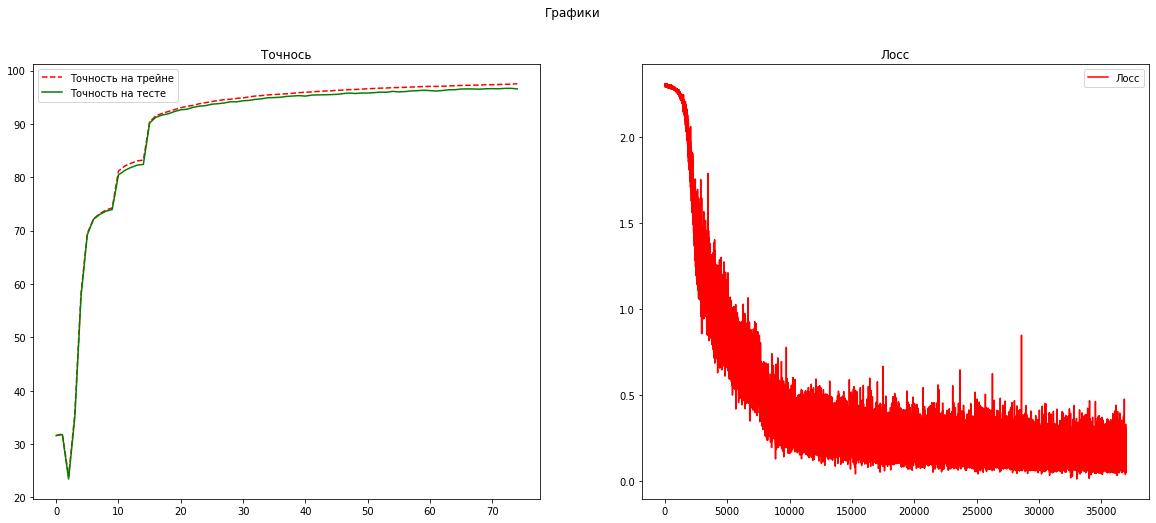

In [752]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Графики")

axs[0].set_title("Точнось")
axs[0].plot(history["train_accuracy"], "--", c="red")
axs[0].plot(history["test_accuracy"], "-", c="green")
axs[0].legend(["Точность на трейне", "Точность на тесте"])

axs[1].set_title("Лосс")
axs[1].plot(history["train_loss"], c="red")
axs[1].legend(["Лосс"])

Лучший результат, который получился - 96%